In [ ]:
# V0.20

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
class Model(nn.Module): # model class object inherited from nn.Module
    
    def __init__(self, in_features=55, h1=80, h2=80, out_features=4):
        # how many layers?
        super().__init__()  # this instanciates the Module class we're inheriting from.
        
        # Input Layer (4 features) --> h1 (hidden layer) N --> h2 (hidden layer) N --> output (3 classes) - of flowers in this case.
        self.fc1 = nn.Linear(in_features, h1) # fully conected (layer 1) i/o
        self.fc2 = nn.Linear(h1,h2)  # i/o
        self.out = nn.Linear(h2, out_features) # i/o
    
    def forward(self, x):
        x = F.relu(self.fc1(x))  # relu = rectified linear unit)
        x = F.relu(self.fc2(x))
        x = self.out(x) 
        
        # we're passing the values through the activation in and out.
        # this is forward propigation.
        
        return x

In [52]:
torch.manual_seed(32)
model = Model()

In [53]:
# Data file produced by tests.
tdf = pd.read_csv('./CSV/colour_data_clustered.csv')

In [54]:
tdf = tdf[['user', 'correct', 'recorded_result', 'mask_image', 'cb_type1', 'cb_type2','ncb', 'cluster_classification']]
tdf.head()

,user,correct,recorded_result,mask_image,cb_type1,cb_type2,ncb,cluster_classification
0,unknown_1,1,5,5,0,0,1,0
1,unknown_1,1,C,C,0,0,1,0
2,unknown_1,1,D,D,0,0,1,0
3,unknown_1,1,N,N,0,0,1,0
4,unknown_1,0,N,E,0,0,1,0


In [55]:
tdf.user.nunique(), tdf.cluster_classification.nunique()

(30, 4)

In [56]:
len(tdf)

5821

In [57]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user                    5821 non-null   object
 1   correct                 5821 non-null   int64 
 2   recorded_result         5821 non-null   object
 3   mask_image              5821 non-null   object
 4   cb_type1                5821 non-null   int64 
 5   cb_type2                5821 non-null   int64 
 6   ncb                     5821 non-null   int64 
 7   cluster_classification  5821 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 363.9+ KB


In [65]:
# # seperate column types
cat_cols = ['user', 'correct', 'recorded_result', 'mask_image', 'cb_type1', 'cb_type2','ncb']
y_col = ['cluster_classification']  # this column contains the labels

# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    tdf[cat] = tdf[cat].astype('category')

user = tdf['user'].cat.codes.values
correct = tdf['correct'].cat.codes.values
recorded_result = tdf['recorded_result'].cat.codes.values
mask_image = tdf['mask_image'].cat.codes.values
cb_type1 = tdf['cb_type1'].cat.codes.values
cb_type2 = tdf['cb_type2'].cat.codes.values
ncb = tdf['ncb'].cat.codes.values

catagorical_features = np.stack([user, correct, recorded_result, mask_image, cb_type2, cb_type2, ncb], 1)

catagorical_features[:5]
# this is a far better way to encode values.

# or in a single line
# catagorical_features = np.stack([tdf[col].cat.codes.values for col in cat_cols], axis=1)

catagorical_features = torch.tensor(catagorical_features, dtype=torch.int64) 


# Convert labels to a tensor
y = tdf[y_col].astype('category')
# y = tdf[y_col].cat.codes.values
y = torch.tensor(tdf[y_col].values, dtype=torch.float).reshape(-1,1)


In [66]:
# OneHotEncode
user_dummies = pd.get_dummies(tdf['user'], prefix='user_', drop_first=True)
recorded_result_dummies = pd.get_dummies(tdf['recorded_result'], prefix='recorded_result_', drop_first=True)
mask_image_dummies = pd.get_dummies(tdf['mask_image'], prefix='mask_image_', drop_first=True)

tdf = pd.concat([tdf,user_dummies,recorded_result_dummies,mask_image_dummies], axis=1)



In [67]:
tdf = tdf.drop(['user','recorded_result','mask_image'], axis=1, inplace=False)

In [68]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   correct                     5821 non-null   category
 1   cb_type1                    5821 non-null   category
 2   cb_type2                    5821 non-null   category
 3   ncb                         5821 non-null   category
 4   cluster_classification      5821 non-null   int64   
 5   user__colourblind_type1_3   5821 non-null   uint8   
 6   user__colourblind_type2_11  5821 non-null   uint8   
 7   user__colourblind_type2_24  5821 non-null   uint8   
 8   user__female_16             5821 non-null   uint8   
 9   user__female_17             5821 non-null   uint8   
 10  user__female_ncb_26         5821 non-null   uint8   
 11  user__female_ncb_29         5821 non-null   uint8   
 12  user__male_12               5821 non-null   uint8   
 13  user__male_13     

In [69]:
# We now need to adjust the number of features in our layers.
len(tdf.columns)
# this is the number of features.

56

In [70]:
X = tdf.drop('cluster_classification', axis=1)
y = tdf['cluster_classification']

In [71]:
type(y) # we need numpy arrays.

pandas.core.series.Series

In [72]:
X = X.values
y = y.values

In [73]:
type(y)

numpy.ndarray

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [76]:
# Convert to FloatTensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [77]:
y_train = torch.LongTensor(y_train) # Long
y_test = torch.LongTensor(y_test)

In [78]:
# "criterion on which we are evaluating our networks performance"
# CrossEntropyLoss - "dataset is a multi-class cross entropy problem".
criterion = nn.CrossEntropyLoss() # Comparing our X_train to X_test

In [79]:
# notice we pass our model function object into the optimiser!
# Adam optimiser - one of the most efficient optimisers.
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)  # start here and change if after 10 epochs error is not reducing.

In [80]:
model.parameters # from our class object

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=55, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (out): Linear(in_features=80, out_features=4, bias=True)
)>

#### How Many Epochs?
- An epoch is 1 run through all the training data

In [81]:
epochs = 100
losses = []

for i in range(epochs):
    
    # FORWARDS and get a prediction
    
    y_pred = model.forward(X_train) # goes forward through all the layers.
    
    # Calculate loss/error
    loss = criterion(y_pred, y_train)
    
    losses.append(loss) # keep track of loss.
    
    if i%10 == 0:
        print(f'Epoch {i} and loss is: {loss}')
              
    # BACK PROPAGATION
              
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch 0 and loss is: 1.396665334701538
Epoch 10 and loss is: 0.48063957691192627
Epoch 20 and loss is: 0.3123609125614166
Epoch 30 and loss is: 0.24453780055046082
Epoch 40 and loss is: 0.16790921986103058
Epoch 50 and loss is: 0.09741850197315216
Epoch 60 and loss is: 0.0210780818015337
Epoch 70 and loss is: 0.0016890435945242643
Epoch 80 and loss is: 0.00039347223355434835
Epoch 90 and loss is: 0.00017870405281428248


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

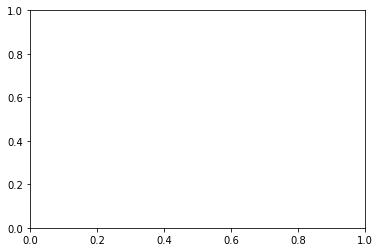

In [83]:
plt.plot(range(epochs),losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [84]:
with torch.no_grad(): # this turns off grad - saves memory and improves efficency.
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)

In [85]:
loss
# Looks like our data is too simple.
# Our test loss is tiny, meaning the score is almost perfect.

tensor(0.0001)

In [86]:
#  Using Cross Entropy Loss followed by Correct Value.

correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
#         print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        
        # add correct to total tally.
        if y_val.argmax().item() == y_test[i]:
            correct += 1
            
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')


1165 out of 1165 = 100.00% correct


In [87]:
# Again, this suggests we need to improve our test mechanism.

In [88]:
torch.save(model.state_dict(), 'colourdata_classification_model.pt')

In [89]:
model2 = Model()
model2.load_state_dict(torch.load('colourdata_classification_model.pt'))

<All keys matched successfully>

In [90]:
model2.eval()

Model(
  (fc1): Linear(in_features=55, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (out): Linear(in_features=80, out_features=4, bias=True)
)

### Inference

In [98]:
import time

In [113]:
start_time = time.time()
random_row = tdf.drop('cluster_classification', axis=1)  # Take X and drop target
random_row = random_row.sample(n=1)  # Select Random Row from X
random_row = random_row.values  # Change into numpy array
random_row = torch.FloatTensor(random_row)  # Convert that into a torch Float
random_row = [t.numpy() for t in random_row]  # Convert items in list to numpy values
inference_sample = torch.tensor([random_row]) # Convert into torch tensor ready for inference.

with torch.no_grad():
    print(model2(inference_sample)) # prints out a tensor
    print('---'*17)
    print(f'Predicted user colour vision type: {model2(inference_sample).argmax()}')
    print('---'*17)
    print("--- %s seconds ---" % (time.time() - start_time))

tensor([[[-3.1299,  8.4188, -5.8482, -0.3840]]])
---------------------------------------------------
Predicted user colour vision type: 1
---------------------------------------------------
--- 0.0056400299072265625 seconds ---


In [ ]:
# Then I just need to add these together and I can derive a mean pr.

In [ ]:
# Consider cleaning with NP cats = np.stack([tdf[col].cat.codes.values for col in cat_cols], axis=1)b